In [1]:
import numpy as np

import pandas as pd

import pymc3 as pm

import statsmodels.api as sm  

import matplotlib.pyplot as plt
import seaborn as sns

from modules.visualization import bayesian_comparison

In [2]:
TYPE = 'non_smoothed'

df = pd.read_csv(f'data\\df_{TYPE}.csv')

In [3]:
CLUSTERING = 'rnn'

In [4]:
df_modelling = df[df['nth_match'] > 95]
df_modelling = df_modelling[df_modelling[f'{CLUSTERING}_clusters'] != -1]

random_sample = int(len(df_modelling['account_id'].unique()) * 0.1)

random_users = np.random.choice(df_modelling['account_id'].unique(), random_sample, replace=False)
df_modelling = df_modelling[df_modelling['account_id'].isin(random_users)]
df_modelling = df_modelling[['account_id', 'position', f'{CLUSTERING}_clusters', 'gpm']]
df_modelling.head(20)

,account_id,position,hdb_clusters,gpm
175,8520,UTILITY,5,341.444533
176,8520,UTILITY,5,318.317757
177,8520,UTILITY,5,268.301887
178,8520,UTILITY,5,269.018868
179,8520,UTILITY,5,287.038492
265,9855,MIDDLE,3,617.146866
266,9855,JUNGLE,3,623.584521
267,9855,JUNGLE,3,316.439444
268,9855,MIDDLE,3,325.555556
269,9855,BOTTOM,3,520.484239


<AxesSubplot:xlabel='hdb_clusters', ylabel='gpm'>

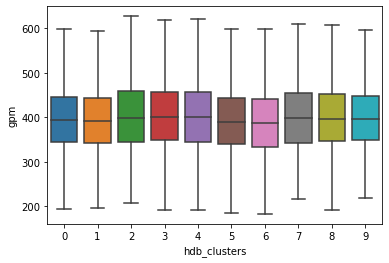

In [5]:
sns.boxplot(
    x=f'{CLUSTERING}_clusters',
    y='gpm',
    data=df_modelling,
    showfliers=False,
)

In [5]:
df_modelling.describe()

,account_id,hdb_clusters,gpm
count,7.301500e+04,73015.000000,73015.000000
mean,2.011281e+08,3.817435,400.528821
std,5.217092e+07,2.732784,78.835969
min,8.520000e+03,0.000000,153.157895
25%,2.052445e+08,1.000000,345.099242
50%,2.170307e+08,3.000000,395.805912
75%,2.243800e+08,5.000000,449.652485
max,2.577408e+08,9.000000,857.153748


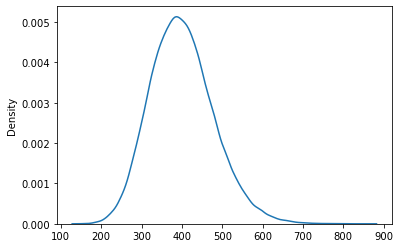

In [6]:
sns.kdeplot(
    df_modelling['gpm'].values
)

df_modelling['gpm'] = (df_modelling['gpm'] - df_modelling['gpm'].mean()) / df_modelling['gpm'].std()

<AxesSubplot:ylabel='Density'>

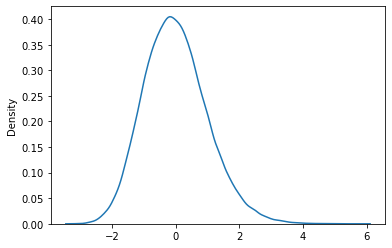

In [7]:
sns.kdeplot(
    df_modelling['gpm'].values
)

## Frequentist Regressions Statsmodels

## PyMC3 Models

In [8]:
account_unique = df_modelling['account_id'].unique()
account_mapping = {account: code for code, account in enumerate(account_unique)}
accounts = np.array([account_mapping[account] for account in df_modelling['account_id'].values])

positions_unique = df_modelling['position'].unique()
positions_mapping = {position: code for code, position in enumerate(positions_unique)}
positions = np.array([positions_mapping[position] for position in df_modelling['position'].values])

clusters_unique = [cluster for cluster in range(len(df_modelling[f'{CLUSTERING}_clusters'].unique()))]
clusters = df_modelling[f'{CLUSTERING}_clusters'].values

gpm = df_modelling['gpm'].values

### Fixed-Intercept Model Pymc3

In [9]:
coords = {
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as fixed_intercept_model:
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )

    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )

    outcome_mu = pm.Deterministic(
        'Mu = Slope Clusters',
        slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    
    outcome = pm.Normal(
        mu=outcome_mu,
        sd=outcome_sd,
        name='Outcome',
        observed=gpm
    )

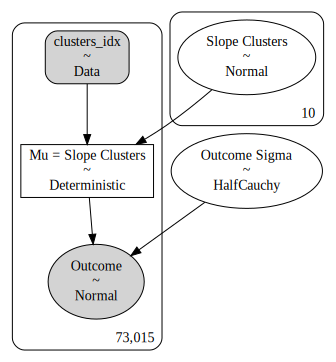

In [10]:
with fixed_intercept_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [12]:
with fixed_intercept_model:
    
    fixed_intercept_traces = pm.sample(
        target_accept=0.9,
        discard_tuned_samples=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Outcome Sigma, Slope Clusters]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.


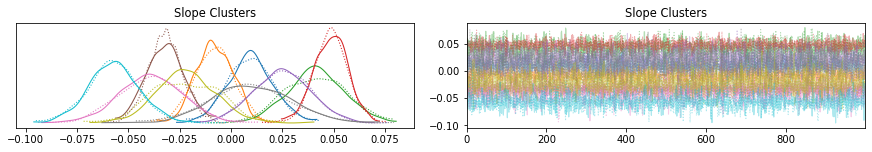

In [13]:
with fixed_intercept_model:
    
    pm.traceplot(
        fixed_intercept_traces,
        var_names=['Slope Clusters']
    )

C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

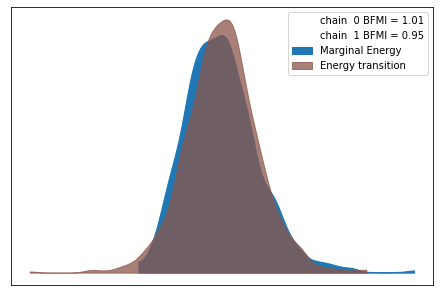

In [14]:
pm.energyplot(fixed_intercept_traces)

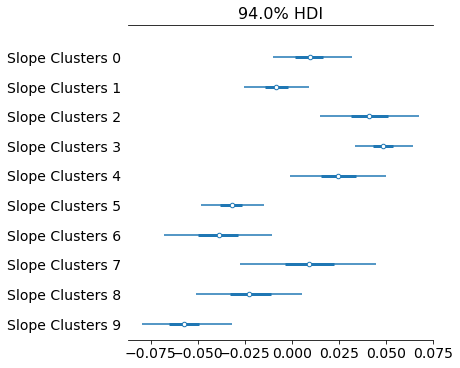

In [15]:
with fixed_intercept_model:
    
    pm.plot_forest(
        fixed_intercept_traces,
        var_names=['Slope Clusters'],
        combined=True
    )

### Random-Intercept Position Model PyMC3

In [16]:
coords = {
    'Positions': positions_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_position_model:
    position_idx = pm.Data(
        'positions_idx',
        positions,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    
    # POSITION
    hyper_sd_position = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Position'
    )
    hyper_mu_position = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Position',
        
    )    
    
    # build the intercept
    
    # POSITION
    intercept = pm.Normal(
        mu=hyper_mu_position,
        sd=hyper_sd_position,
        name='Position Varying Intercept',
        dims='Positions'
    )
    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    # Create the model
    outcome_mu = pm.Deterministic(
        'Mu',
        intercept[position_idx] + slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    
    outcome = pm.Normal(
        mu=outcome_mu,
        sd=outcome_sd,
        name='Outcome',
        observed=gpm
    )

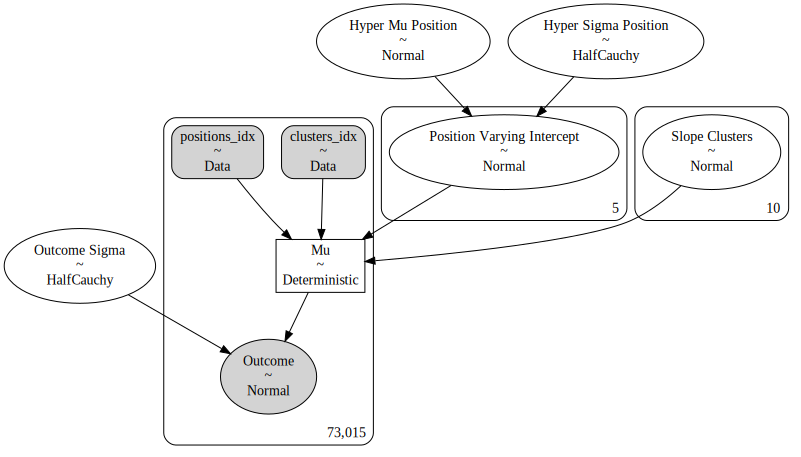

In [17]:
with random_position_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [18]:
with random_position_model:
    
    random_position_traces = pm.sample(
        target_accept=0.9,
        discard_tuned_samples=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Outcome Sigma, Slope Clusters, Position Varying Intercept, Hyper Mu Position, Hyper Sigma Position]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1144 seconds.
The number of effective samples is smaller than 25% for some parameters.


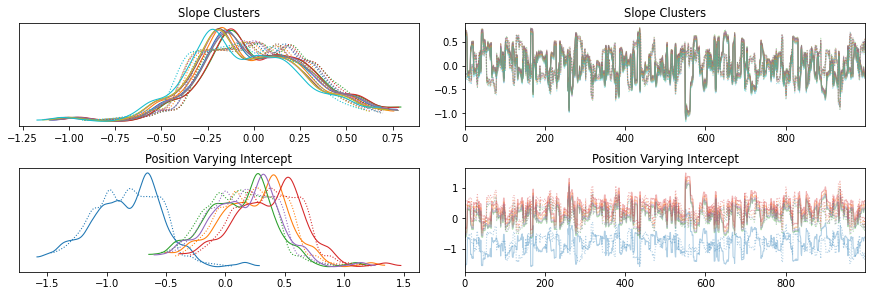

In [19]:
with random_position_model:
    
    pm.traceplot(
        random_position_traces,
        var_names=[
            'Slope Clusters',
            'Position Varying Intercept'
            
        ]
    )

C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

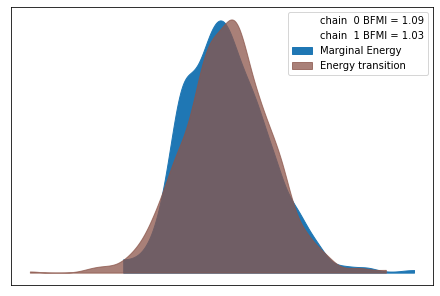

In [20]:
pm.energyplot(random_position_traces)

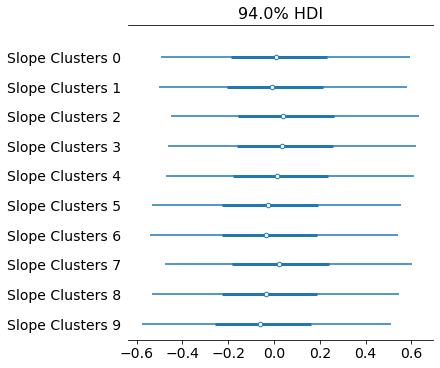

In [21]:
with random_position_model:
    
    pm.plot_forest(
        random_position_traces,
        var_names=['Slope Clusters'],
        combined=True
    )

### Random-Intercept Account ID Model PyMC3

In [22]:
coords = {
    'Accounts': account_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_bins_model:
    account_idx = pm.Data(
        'account_idx',
        accounts,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    
    # ACCOUNTS
    hyper_sd_accounts = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Accounts'
    )
    hyper_mu_accounts = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Accounts',
        
    )
    
    # build the intercept
    
    # BINS
    accounts_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Accounts Varying Theta Tilde',
        dims='Accounts'
    )
    accounts_theta = pm.Deterministic(
        'Bins Varying Theta',
        hyper_mu_accounts + hyper_sd_accounts * accounts_theta_tilde
    )

    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    
    # Create the model
    outcome_mu = pm.Deterministic(
        'Mu',
        accounts_theta[account_idx] + slope_cluster[clusters_idx]
    )
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    
    outcome = pm.Normal(
        mu=outcome_mu,
        sd=outcome_sd,
        name='Outcome',
        observed=gpm
    )

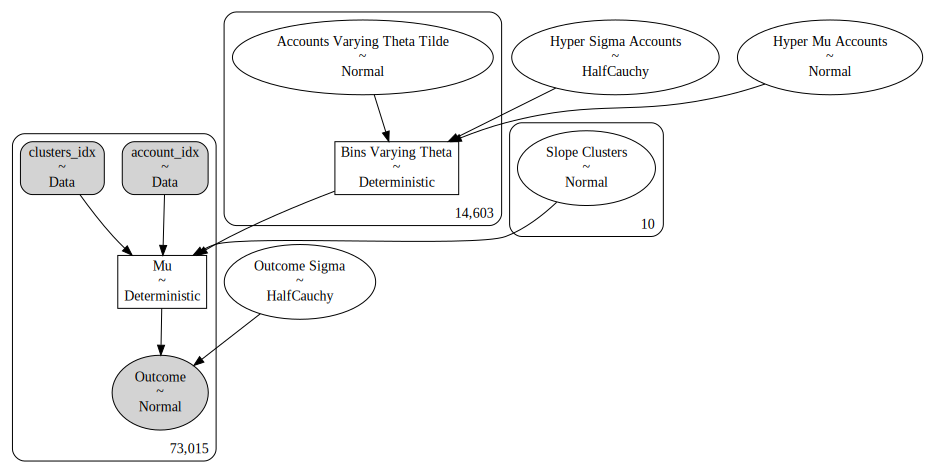

In [23]:
with random_bins_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [24]:
with random_bins_model:
    
    random_bins_traces = pm.sample(
        target_accept=0.9, 
        tune=2000, 
        draws=2000,
        discard_tuned_samples=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Outcome Sigma, Slope Clusters, Accounts Varying Theta Tilde, Hyper Mu Accounts, Hyper Sigma Accounts]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10129 seconds.
The number of effective samples is smaller than 10% for some parameters.


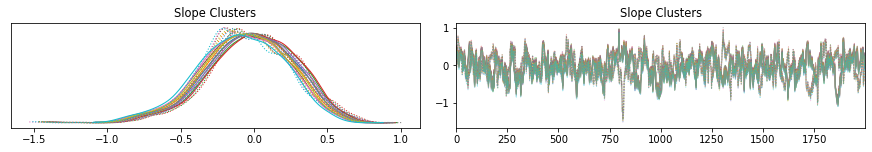

In [25]:
with random_bins_model:
    
    pm.traceplot(
        random_bins_traces,
        var_names=[
            'Slope Clusters'
        ]
    )

C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

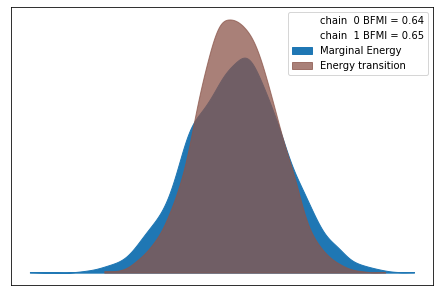

In [26]:
pm.energyplot(random_bins_traces)

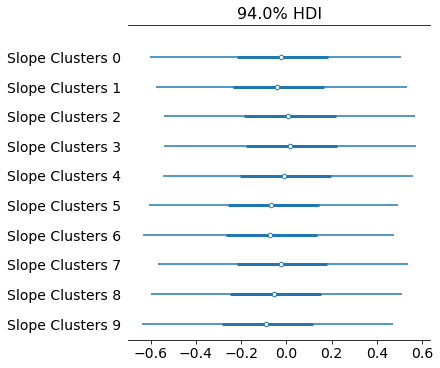

In [27]:
with random_bins_model:
    
    pm.plot_forest(
        random_bins_traces,
        var_names=['Slope Clusters'],
        combined=True
    )

### Random-Intercept Position - Account ID -  PyMC3

In [28]:
coords = {
    'Accounts': account_unique,
    'Positions': positions_unique,
    'Clusters': clusters_unique,
    'Observations': np.arange(gpm.size)
}

with pm.Model(coords=coords) as random_pos_bins_model:
    account_idx = pm.Data(
        'account_idx',
        accounts,
        dims='Observations'
    )
    position_idx = pm.Data(
        'positions_idx',
        positions,
        dims='Observations'
    )
    clusters_idx = pm.Data(
        'clusters_idx',
        clusters,
        dims='Observations'
    )
     
    # HYPER-PRIORS
    
    # BINS
    hyper_sd_accounts = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Accounts'
    )
    hyper_mu_accounts = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Accounts',
        
    )
    
    # POSITION
    hyper_sd_position = pm.HalfCauchy(
        beta=1,
        name='Hyper Sigma Position'
    )
    hyper_mu_position = pm.Normal(
        mu=0,
        sigma=1,
        name='Hyper Mu Position',
        
    )    
    
    # build the intercept
    
    # BINS
    accounts_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Accounts Varying Theta Tilde',
        dims='Accounts'
    )
    accounts_theta = pm.Deterministic(
        'Bins Varying Theta',
        hyper_mu_accounts + hyper_sd_accounts * accounts_theta_tilde
    )
    
    # POSITION
    position_theta_tilde = pm.Normal(
        mu=0,
        sd=1,
        name='Positions Varying Theta Tilde',
        dims='Positions'
    )
    position_theta = pm.Deterministic(
        'Positions Varying Theta',
        hyper_mu_position + hyper_sd_position * position_theta_tilde
    )

    
    intercept = pm.Deterministic(
        'Varying Intercept',
        accounts_theta[account_idx] + position_theta[position_idx]
    )
    
    # Look at the effect of clusters
    slope_cluster = pm.Normal(
        mu=0,
        sd=1,
        name='Slope Clusters',
        dims='Clusters'
    )
    
    # Create the model
    outcome_mu = intercept + slope_cluster[clusters_idx]
    outcome_sd = pm.HalfCauchy(
        beta=1,
        name='Outcome Sigma'
    )
    
    outcome = pm.Normal(
        mu=outcome_mu,
        sd=outcome_sd,
        name='Outcome',
        observed=gpm
    )

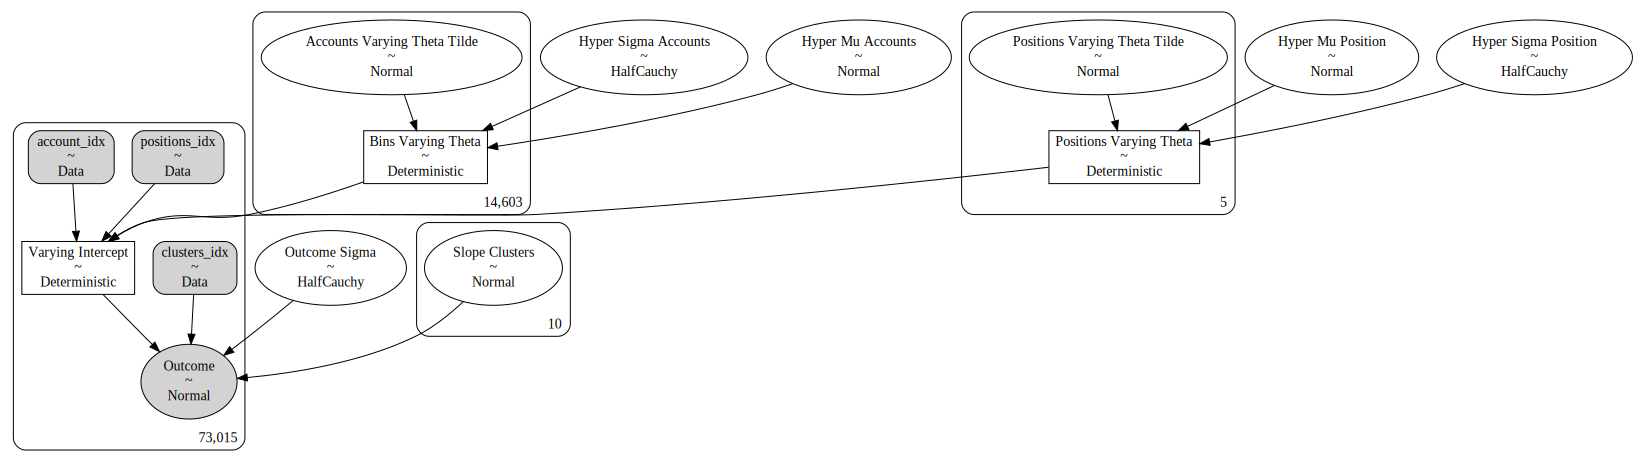

In [29]:
with random_pos_bins_model:
    
    plate = pm.model_graph.model_to_graphviz()

plate

In [30]:
with random_pos_bins_model:
    
    random_pos_bins_traces = pm.sample(
        target_accept=0.9, 
        discard_tuned_samples=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Outcome Sigma, Slope Clusters, Positions Varying Theta Tilde, Accounts Varying Theta Tilde, Hyper Mu Position, Hyper Sigma Position, Hyper Mu Accounts, Hyper Sigma Accounts]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21361 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


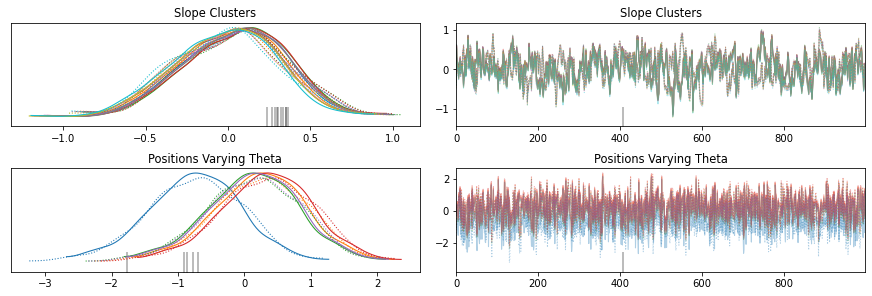

In [31]:
with random_pos_bins_model:
    
    pm.traceplot(
        random_pos_bins_traces,
        var_names=[
            'Slope Clusters',
            'Positions Varying Theta'
            
        ]
    )

C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

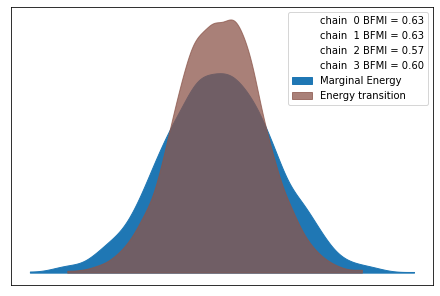

In [32]:
pm.energyplot(random_pos_bins_traces)

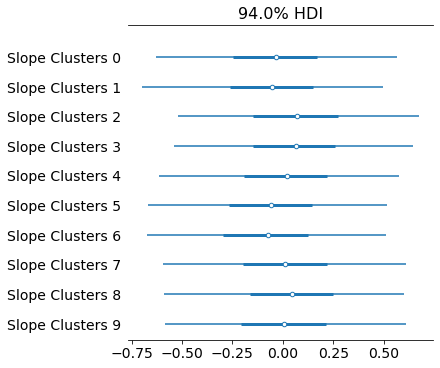

In [33]:
with random_pos_bins_model:
    
    pm.plot_forest(
        random_pos_bins_traces,
        var_names=['Slope Clusters'],
        combined=True
    )

## Model Comparison

In [32]:
compare_df = pm.compare(
    {
        'Fixed Intercept': fixed_intercept_traces, 
        'Random Position': random_position_traces,
        'Random Accounts': random_bins_traces,
        'Random Position Accounts': random_pos_bins_traces
    },
    scale='deviance'
)

C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\penthotal\miniconda3\envs\workshop_env\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument o

<AxesSubplot:xlabel='Deviance'>

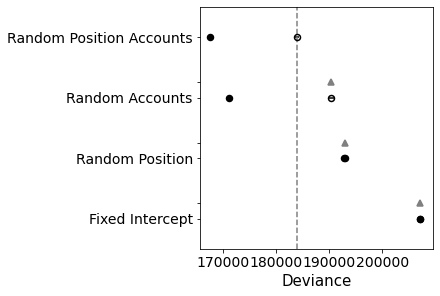

In [33]:
pm.compareplot(compare_df)

In [34]:
compare_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Random Position Accounts,0,183873,8163.4,0,1,425.418,0,True,deviance
Random Accounts,1,190332,9660.27,6459.12,0,449.926,169.868,True,deviance
Random Position,2,192851,15.0069,8977.74,0,442.97,202.754,False,deviance
Fixed Intercept,3,207142,10.957,23268.9,0,446.643,278.389,False,deviance
